In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics

# Demonstrating supervised learning methodologies as an intervention for adverse impact in hiring with biased selection tools

## Problem
+ idea of predictive validity
+ US based
+ define adverse impact, effect sizes(cohens d)
+ I/Os are slow to adopt new methodologies
+ difficulty of race related research
+ goal of minimizing group differences

## About the data
+ this is a simulation based on metaanlytic correlations

## EDA
In this case, exploaratory data analysis is largely unnecesary since this is a dataset I constructed based on a literature review. I'll use it to better frame the issue though.

In [2]:
#my dataset created in _url_
data = pd.read_csv('sim_AI_dataset.csv')

In [82]:
data.info()
#no missing values, all variables are numerical. 'group' is categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142857 entries, 0 to 142856
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Cognitive Ability     142857 non-null  float64
 1   Education             142857 non-null  float64
 2   Experience            142857 non-null  float64
 3   Structured Interview  142857 non-null  float64
 4   Conscientiousness     142857 non-null  float64
 5   Performance           142857 non-null  float64
 6   group                 142857 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 7.6 MB


In [3]:
#dropping the previous index
data.drop('Unnamed: 0', inplace=True, axis=1)

When building a model to select employees the must common predictor variable is job performance. Other variables like turnover can be used, but it is less common and there is less literature. When I talk about prediction in this project, I am referring to predicting job performance.

We have 5 predictor variables. I'll discuss each in turn. All relationships between performance and predictors are based on metaanlytic correlations in Schmidt et al. 2016, I'll put this in my gitlab project if you're interested.

Because this is simulated data and all of these variables can be measured on many different scales, I arbitrarily set the population mean=5 and standard deviation=1 for the majority group, then derived the minority population means based on effect sizes documented in the literature. 

In [83]:
data.describe()

,Cognitive Ability,Education,Experience,Structured Interview,Conscientiousness,Performance,group
count,142857.000000,142857.000000,142857.000000,142857.000000,142857.000000,142857.000000,142857.000000
mean,4.784739,4.997192,4.998804,4.906265,5.002314,4.998800,0.299999
std,1.051571,1.002302,1.000912,1.009893,1.000983,0.999417,0.458259
min,-0.126445,0.154641,0.431966,0.518082,-0.097069,0.594579,0.000000
25%,4.077989,4.321539,4.325366,4.225208,4.322711,4.326723,0.000000
50%,4.787958,4.997714,4.998253,4.909872,5.003235,5.000557,0.000000
75%,5.501317,5.676376,5.672297,5.585685,5.678019,5.673711,1.000000
max,9.034405,9.234118,9.149128,9.173655,9.731200,9.326955,1.000000


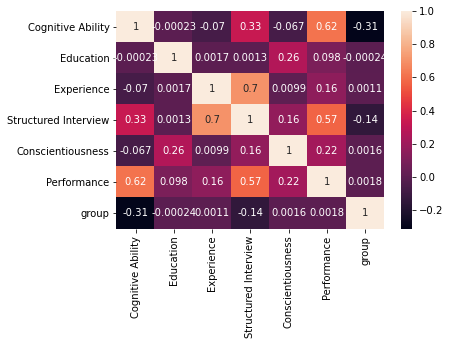

In [111]:
sn.heatmap(data.corr(),annot=True)

#### Cognitive ability
Cognitive ability is the best predictor of job performance we have across the board. It has a .65 correlation with performance. In social science research a relationship that strong is exteremely rare. However, selecting on cognitive ability results in disparate impact especially between white and black subgroups. This means that if we only use cognitive ability to choose who to hire, a higher percentage of white applicants will be hired than black applicants. Generally, it is debated whether the cause of the subgroup differences are because cognitive ability is less predicitive for blacks than for whites(called differential validity) or if it is an simply an artifcat of range restriction in the applicant pool. A effect size of up to 1.0 is often observed, in this project I used .72 which was taken from the literature. The minority population(group=1) is 13.4% of the overall population which is the percentage of the US population that is black.

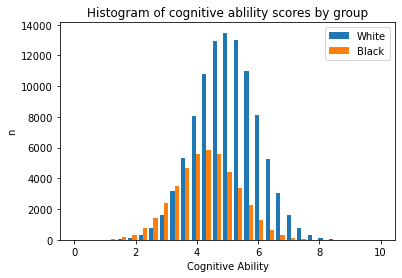

In [100]:
bins = np.linspace(0, 10, 30)
plt.hist([data[data['group']==0]['Cognitive Ability'], data[data['group']==1]['Cognitive Ability']], bins, label=['White', 'Black'])
plt.legend(loc='upper right')
plt.title('Histogram of cognitive ablility scores by group')
plt.ylabel('n')
plt.xlabel('Cognitive Ability')
plt.show()

#### Education and Experience
Education and experience both are very weak predictors of job performance (r=.1 and r=.16 respectively), yet are very commonly used in hiring which is why I included them in my model. I could not find documentented sub-group differences, so I set the effect size for both as 0. These variables are on the same continuous scale as our other predictors, but how they are measured in practice varies. Sometimes they become categorical variables like 'High school diploma', or number of years of education, etc.

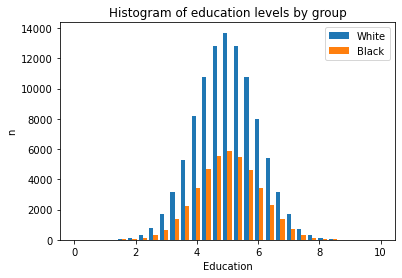

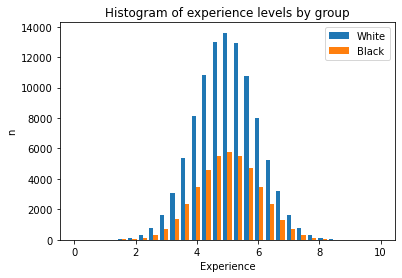

In [102]:
bins = np.linspace(0, 10, 30)
plt.hist([data[data['group']==0]['Education'], data[data['group']==1]['Education']], bins, label=['White', 'Black'])
plt.legend(loc='upper right')
plt.title('Histogram of education levels by group')
plt.ylabel('n')
plt.xlabel('Education')
plt.show()

bins = np.linspace(0, 10, 30)
plt.hist([data[data['group']==0]['Experience'], data[data['group']==1]['Experience']], bins, label=['White', 'Black'])
plt.legend(loc='upper right')
plt.title('Histogram of experience levels by group')
plt.ylabel('n')
plt.xlabel('Experience')
plt.show()

#### Structured Interview
A structured interview is essentially an interview with rules placed around it to try and create a similar experience for each candidate. The level of structure can vary- candidataes can all be asked the same set of questions, scoring can be done based on a rubric with anchored scores. Highly structured interviews tend to be less biased and more predictive than unstructured interviews. Yet both interviewers and interviewees tend to dislike them. Sturctured interviews have good predictive validity (r=0.58) yet also have score differnces between white and black subgroups (d=0.31).

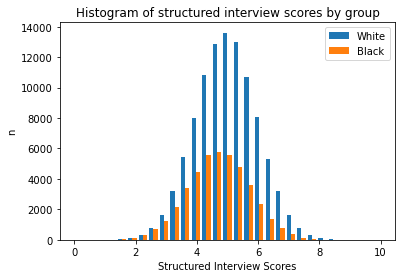

In [103]:
bins = np.linspace(0, 10, 30)
plt.hist([data[data['group']==0]['Structured Interview'], data[data['group']==1]['Structured Interview']], bins, label=['White', 'Black'])
plt.legend(loc='upper right')
plt.title('Histogram of structured interview scores by group')
plt.ylabel('n')
plt.xlabel('Structured Interview Scores')
plt.show()

#### Conscientiousness
Conscientiousness is a personality trait that also uniformly predicts performance (r=.22). While it does not nearly have the predictive power as cognitive ability it does not have black-white subgroup differences. Additionally, it is uncorrelated with cognitive ability. Because of these facets, it is often used in combination with cognitive ability to offset some of the group differences while still increacing prediction.  

## Analysis

In [ ]:
### Methods
### Selection Ratios
### Evaluation Criteria

In [114]:
ratios = [.05,.1,.3,.5,.8]

In [115]:
### Creating a baseline with linear regression

In [116]:
### The first thing I did was to create funct that returns evaluation criteria based on a certail selection ration
def evaluate(df, selection_column, group_column='group', selection_ratio=.30):
    col_name = str(selection_ratio*100) + 'pct'
    #create classes based on selection ratio
    df[col_name] = 0
    df.loc[eval_df[selection_column] >= 1-selection_ratio, col_name] = 1
    
    y_test_eval[col_name] = 0
    y_test_eval.loc[y_test_eval['Performance']>=1-selection_ratio, col_name] = 1
    
    #calc group selection ratios and impact ratio
    tmp = df.groupby([group_column])[['const',col_name]].sum().reset_index()
    selection_pct = tmp[str(selection_ratio*100) + 'pct']/tmp['const']
    impactratio = selection_pct[1]/selection_pct[0]

    #standard model eval metrics to compare methods
    acc = metrics.accuracy_score(y_test_eval[col_name], df[col_name])
    #conf_mat = metrics.confusion_matrix(y_test_eval[col_name], df[col_name])
    f1 = metrics.f1_score(y_test_eval[col_name], df[col_name])
    
    #minority selection, majority selection, ratio for adverse impact
    return selection_pct[1],selection_pct[0],impactratio,acc,f1#,conf_mat

In [117]:
#create training and test data
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, ~data.columns.isin(['Performance'])], data['Performance'], test_size=0.30)

In [118]:
#this will be used to select the top x% to evaluate later on
y_test_eval = pd.DataFrame(y_test.rank(pct=True))

In [119]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Performance   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                 2.883e+04
Date:                Sun, 19 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:07:48   Log-Likelihood:                -91643.
No. Observations:               99999   AIC:                         1.833e+05
Df Residuals:                   99992   BIC:                         1.834e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1574 

In [123]:
eval_df = X_test
X_test = sm.add_constant(X_test)
eval_df['pred_val'] =results.predict(X_test)
eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

for i in ratios:
    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[3],2))

0.05 selection ratio:  Accuracy:  0.95 F1 score:  0.49 Impact ratio:  0.95
0.1 selection ratio:  Accuracy:  0.91 F1 score:  0.56 Impact ratio:  0.91
0.3 selection ratio:  Accuracy:  0.82 F1 score:  0.7 Impact ratio:  0.82
0.5 selection ratio:  Accuracy:  0.79 F1 score:  0.79 Impact ratio:  0.79
0.8 selection ratio:  Accuracy:  0.86 F1 score:  0.91 Impact ratio:  0.86


My first model is purely for illustartation, with all 5 predictors and group we achieve an adjusted r^2 of .633. This is below the theoretical r^2 we would achieve with these predictors based on the literture, but that's not concerning. (In practice, it's always below the literature). All predictors are significant. Interestingly, the coefficient for experience is negative though positively correlated to performance-- I suspect due to high collinearity with other predictors.

Moving forward we will not be using group as a predictive variable because it is not representative of actual practice and is part of our evaluation criteria.

In [12]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train.loc[:, ~X_train.columns.isin(['group'])])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Performance   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                 2.789e+04
Date:                Sun, 19 Jun 2022   Prob (F-statistic):               0.00
Time:                        09:18:48   Log-Likelihood:                -98140.
No. Observations:               99999   AIC:                         1.963e+05
Df Residuals:                   99993   BIC:                         1.963e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3611 

In [ ]:
eval_df = X_test
X_test = sm.add_constant(X_test)
eval_df['pred_val'] =results.predict(X_test.loc[:, ~X_test.columns.isin(['group'])])
eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

for i in ratios:
    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[3],2))

Without group our Adj. R^2 falls to .582 with all of our variables still significant. Now I'll try dropping a few variables based on their correlations with performance.

In [108]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train.loc[:, ~X_train.columns.isin(['group','Education'])])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Performance   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                 3.439e+04
Date:                Sun, 19 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:57:23   Log-Likelihood:                -98537.
No. Observations:               99999   AIC:                         1.971e+05
Df Residuals:                   99994   BIC:                         1.971e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5628 

In [ ]:
eval_df = X_test
X_test = sm.add_constant(X_test)
eval_df['pred_val'] =results.predict(X_test.loc[:, ~X_test.columns.isin(['group','Education'])])
eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

for i in ratios:
    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[3],2))

In [106]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train.loc[:, ~X_train.columns.isin(['group','Education','Experience'])])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Performance   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                 4.337e+04
Date:                Sun, 19 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:57:00   Log-Likelihood:            -1.0013e+05
No. Observations:               99999   AIC:                         2.003e+05
Df Residuals:                   99995   BIC:                         2.003e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0604 

In [ ]:
eval_df = X_test
X_test = sm.add_constant(X_test)
eval_df['pred_val'] =results.predict(X_test.loc[:, ~X_test.columns.isin(['group','Education','Experience'])])
eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

for i in ratios:
    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[3],2))

In practice I would 

#### Linear regression model summary

In [ ]:
## Decision Trees

In [ ]:
## Boosting